# Spambase Classification

**Name:** Anish Talluri  
**Date:** October 20, 2025

---

## Problem Overview
In this notebook, I apply three linear classification models to the Spambase dataset from the UCI Machine Learning Repository. The goal is to classify emails as spam or non-spam based on 57 features (word frequencies, character frequencies, and capital letter statistics).

## Dataset Information
- **Source:** UCI Machine Learning Repository
- **Samples:** 4,601 emails
- **Features:** 57 numeric features
- **Classes:** Binary (0 = Not Spam, 1 = Spam)
- **Split:** 80% training, 10% development, 10% test

---
**Step 1:** Import all necessary libraries

In [1]:
# Import all needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

np.random.seed(42)  # For reproducibility

---
**Step 2:** Load dataset and create stratified train/dev/test (10/10/80 respectively) splits to ensure balanced class distribution across all sets.

In [2]:
# Load Spambase dataset
# File is located at 'spambase/spambase.data'
data = pd.read_csv('spambase/spambase.data', header=None)

In [3]:
# Split the data (80% train, 10% dev, 10% test)
X = data.iloc[:, :-1] # Features (matrix)
y = data.iloc[:, -1]  # Labels (vector)

# 10% test split --> 10% stored in X_test, y_test (testing set) and 90% in X_temp, y_temp
# (for further splitting)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# 10% dev split --> Uses 90% that's currently in X_temp, y_temp to create 10% dev (development set)
# and stores the 80% into X_train, y_train (training set)
X_train, X_dev, y_train, y_dev = train_test_split(X_temp, y_temp, test_size=1/9, random_state=42, stratify=y_temp)

# Print summary to verify splits
# print("="*50)
# print("DATA SPLIT SUMMARY")
# print("="*50)
# print(f"Total samples: {len(data)}")
# print(f"Training set:   {len(X_train):4d} ({len(X_train)/len(data)*100:.1f}%)")
# print(f"Development set: {len(X_dev):4d} ({len(X_dev)/len(data)*100:.1f}%)")
# print(f"Test set:        {len(X_test):4d} ({len(X_test)/len(data)*100:.1f}%)")
# print(f"\nClass distribution in training set:")
# print(f"  Not Spam (0): {sum(y_train == 0):4d} ({sum(y_train == 0)/len(y_train)*100:.1f}%)")
# print(f"  Spam (1):     {sum(y_train == 1):4d} ({sum(y_train == 1)/len(y_train)*100:.1f}%)")
# print("="*50)

---

**Step 3:** Implement the Perceptron algorithm --> The Perceptron is a linear classifier that learns a decision boundary by updating weights when it makes mistakes.

**Algorithm:**
- Initialize weights and bias to zero
- For each training iteration, update weights when prediction is incorrect
- Update rule: w += learning_rate × y × x (when wrong)

In [4]:
# Implement Perceptron class

class Perceptron:
    def __init__(self, learning_rate=1.0, max_iterations=100, shuffle=True):
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.shuffle = shuffle
    
    def fit(self, X, y):
        y_converted = np.where(y == 0, -1, 1) # Labels converted to -1 and +1

        self.weights = np.zeros(X.shape[1]) # Start with zero weights
        self.bias = 0 # Start with zero bias

        # Training loop
        for _ in range(self.max_iterations): # Repeat for max_iterations
            for i in range(X.shape[0]): # For each training example
                total = np.dot(self.weights, X[i]) + self.bias # Calculate total input

                # Check if prediction is wrong
                if (total * y_converted[i]) <= 0:
                    self.weights += y_converted[i] * X[i] # Update weights
                    self.bias += y_converted[i] # Update bias
        return self

    def predict(self, X):
        # Make predictions
        if X.ndim == 1: # Single example
            total = np.dot(self.weights, X) + self.bias # Calculate total input
            return 1 if total > 0 else 0 # Return class label
        else: # Multiple examples
            totals = np.dot(X, self.weights) + self.bias # Vectorized total inputs
            return np.where(totals > 0, 1, 0) # Return class labels
    
    def score(self, X, y):
        predictions = self.predict(X)
        accuracy = np.mean(predictions == y) # Calculate accuracy
        return accuracy

In [5]:
# Test the Perceptron
print("Testing Perceptron with max_iterations=100")
print("=" * 50)

# Create and train the perceptron
perc = Perceptron(learning_rate=1.0, max_iterations=100)
perc.fit(X_train.values, y_train.values)

# Evaluate on training set
train_accuracy = perc.score(X_train.values, y_train.values)
print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")

# Evaluate on dev set
dev_accuracy = perc.score(X_dev.values, y_dev.values)
print(f"Dev Accuracy:      {dev_accuracy:.4f} ({dev_accuracy*100:.2f}%)")

# Test prediction on a single example
print("\n" + "=" * 50)
print("Testing single prediction:")
sample = X_dev.values[0]
prediction = perc.predict(sample)
actual = y_dev.values[0]
print(f"Predicted: {prediction}, Actual: {actual}, Correct: {prediction == actual}")
print("=" * 50)

Testing Perceptron with max_iterations=100
Training Accuracy: 0.8541 (85.41%)
Dev Accuracy:      0.8674 (86.74%)

Testing single prediction:
Predicted: 0, Actual: 0, Correct: True
Training Accuracy: 0.8541 (85.41%)
Dev Accuracy:      0.8674 (86.74%)

Testing single prediction:
Predicted: 0, Actual: 0, Correct: True


---

**Step 4:** Use the development set to find the optimal `max_iterations` hyperparameter. Testing values: 10, 50, 100, 200, 500.

**Result:** Best performance with max_iterations=500 (91.09% dev accuracy)

In [6]:
# Tune max_iterations using dev set
iteration_vals = [10, 50, 100, 200, 500]  # Values to test

# Store results for each value
for i in iteration_vals:
    perc = Perceptron(learning_rate = 1.0, max_iterations=i)  # Create perceptron with current max_iterations
    perc.fit(X_train.values, y_train.values)  # Train perceptron
    dev_accuracy = perc.score(X_dev.values, y_dev.values)  # Evaluate on dev set

# After reviewing the results above, determine which max_iterations performed best on the dev set
# Note: the dev accuracy kept improving with higher iterations, so we choose the highest one (500 yielded a 91.09% accuracy)


---
**Step 5:** Compare the Perceptron with two other linear models from scikit-learn.

**5A. Linear SVM (LinearSVC):** Tune the regularization parameter C. Higher C means less regularization (more complex model).

**Result:** Best performance with C=1.0 (94.13% dev accuracy)

In [7]:
# Tune LinearSVC
C = [0.001, 0.01, 0.1, 1, 10, 100]  # Regularization parameters to test

for c in C:
    svc = LinearSVC(C=c, max_iter=10000, dual=False)  # Create LinearSVC with current C and max_iterations=10000
    svc.fit(X_train.values, y_train.values)  # Train LinearSVC
    dev_accuracy = svc.score(X_dev.values, y_dev.values)  # Evaluate on dev set

    print(f"C: {c:6.2f} --> Dev Accuracy: {dev_accuracy:.4f} ({dev_accuracy*100:.2f}%)")

# Note: Based on the printed results, it's clearly seen that accuracies improve with higher C values, but one it was at C=1, the C values after that stagnate
# This means that there is no reason to go beyond C=1, and there is less risk of overfitting by going with this instead of C=100 or more

C:   0.00 --> Dev Accuracy: 0.9217 (92.17%)
C:   0.01 --> Dev Accuracy: 0.9283 (92.83%)
C:   0.10 --> Dev Accuracy: 0.9391 (93.91%)
C:   1.00 --> Dev Accuracy: 0.9413 (94.13%)
C:  10.00 --> Dev Accuracy: 0.9413 (94.13%)
C: 100.00 --> Dev Accuracy: 0.9413 (94.13%)
C: 100.00 --> Dev Accuracy: 0.9413 (94.13%)


**5B. Logistic Regression:** Tune both the regularization parameter C and penalty type (L2 regularization vs. none).

**Result:** Best performance with penalty='l2', C=10.0 (94.35% dev accuracy)

In [8]:
# Tune Logistic Regression
penalties = ['l2', 'none']  # Ridge Regularization, No Regularization

for penalty in penalties: 
    for c in C:
        model = LogisticRegression(C=c, penalty=penalty, max_iter=10000)
        model.fit(X_train.values, y_train.values)
        dev_accuracy = model.score(X_dev.values, y_dev.values)

        print(f"Penalty: {penalty:4s}, C: {c:6.3f} --> Dev Accuracy: {dev_accuracy:.4f} ({dev_accuracy*100:.2f}%)")

# Note: Based on the results printed below, the highest accuracy came from within the l2 penaty, when C=10 recorded an accuracy of 94.35%
# This is the optimal pick not only b/c it scored the highest, but also because this is with a penalty (meaning it uses regularization)

Penalty: l2  , C:  0.001 --> Dev Accuracy: 0.8565 (85.65%)
Penalty: l2  , C:  0.010 --> Dev Accuracy: 0.9196 (91.96%)
Penalty: l2  , C:  0.010 --> Dev Accuracy: 0.9196 (91.96%)
Penalty: l2  , C:  0.100 --> Dev Accuracy: 0.9304 (93.04%)
Penalty: l2  , C:  0.100 --> Dev Accuracy: 0.9304 (93.04%)
Penalty: l2  , C:  1.000 --> Dev Accuracy: 0.9413 (94.13%)
Penalty: l2  , C:  1.000 --> Dev Accuracy: 0.9413 (94.13%)
Penalty: l2  , C: 10.000 --> Dev Accuracy: 0.9435 (94.35%)
Penalty: l2  , C: 10.000 --> Dev Accuracy: 0.9435 (94.35%)
Penalty: l2  , C: 100.000 --> Dev Accuracy: 0.9413 (94.13%)
Penalty: l2  , C: 100.000 --> Dev Accuracy: 0.9413 (94.13%)


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Penalty: none, C:  0.001 --> Dev Accuracy: 0.9413 (94.13%)


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Penalty: none, C:  0.010 --> Dev Accuracy: 0.9413 (94.13%)


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Penalty: none, C:  0.100 --> Dev Accuracy: 0.9413 (94.13%)


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


Penalty: none, C:  1.000 --> Dev Accuracy: 0.9413 (94.13%)


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Penalty: none, C: 10.000 --> Dev Accuracy: 0.9413 (94.13%)


c:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\HP\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Penalty: none, C: 100.000 --> Dev Accuracy: 0.9413 (94.13%)


---
**Step 6:** Train final models with best hyperparameters and evaluate on the held-out test set (used only once to get unbiased performance estimates).

In [9]:
# Evaluate all models on test set

print("=" * 60)
print("FINAL TEST SET EVALUATION")
print("=" * 60)

# 1. Perceptron with best hyperparameters (max_iterations=500)
print("\n1. Perceptron (max_iterations=500)")
print("-" * 40)
# Create perceptron with max_iterations=500
perceptron = Perceptron(learning_rate=1.0, max_iterations=500)

# Train on X_train, y_train
perceptron.fit(X_train.values, y_train.values)

# Get test accuracy
test_accuracy = perceptron.score(X_test.values, y_test.values)
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy * 100:.2f}%)")

# Get predictions on test set
y_pred = perceptron.predict(X_test.values)

# Calculate confusion matrix
confusion = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion)


print("=" * 60)


# 2. LinearSVC with best hyperparameters (C=1.0)
print("\n2. LinearSVC (C=1.0)")
print("-" * 40)

# Create LinearSVC with C=1.0, dual=False, max_iter=10000
linear_svc = LinearSVC(C=1.0, dual=False, max_iter=10000)

# Train on X_train, y_train
linear_svc.fit(X_train, y_train)

# Get test accuracy
test_accuracy = linear_svc.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy * 100:.2f}%)")

# Get predictions on test set
y_pred = linear_svc.predict(X_test)
# Calculate confusion matrix
confusion = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion)


print("=" * 60)


# 3. Logistic Regression with best hyperparameters (penalty='l2', C=10.0)
print("\n3. Logistic Regression (penalty='l2', C=10.0)")
print("-" * 40)
# Create LogisticRegression with C=10.0, penalty='l2', max_iter=10000
logistic_regression = LogisticRegression(C=10.0, penalty='l2', max_iter=10000)

# Train on X_train, y_train
logistic_regression.fit(X_train, y_train)

# Get test accuracy
test_accuracy = logistic_regression.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy * 100:.2f}%)")

# Get predictions on test set
y_pred = logistic_regression.predict(X_test)

# Calculate confusion matrix
confusion = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(confusion)


print("\n" + "=" * 60)
print("Questions to think about:")
print("- Which model performed best on the test set?")
print("- How do test accuracies compare to dev accuracies?")
print("- What does each confusion matrix tell you about errors?")
print("=" * 60)

FINAL TEST SET EVALUATION

1. Perceptron (max_iterations=500)
----------------------------------------
Test Accuracy: 0.9002 (90.02%)
Confusion Matrix:
[[251  28]
 [ 18 164]]

2. LinearSVC (C=1.0)
----------------------------------------
Test Accuracy: 0.9154 (91.54%)
Confusion Matrix:
[[262  17]
 [ 22 160]]

3. Logistic Regression (penalty='l2', C=10.0)
----------------------------------------
Test Accuracy: 0.9002 (90.02%)
Confusion Matrix:
[[251  28]
 [ 18 164]]

2. LinearSVC (C=1.0)
----------------------------------------
Test Accuracy: 0.9154 (91.54%)
Confusion Matrix:
[[262  17]
 [ 22 160]]

3. Logistic Regression (penalty='l2', C=10.0)
----------------------------------------
Test Accuracy: 0.9132 (91.32%)
Confusion Matrix:
[[261  18]
 [ 22 160]]

Questions to think about:
- Which model performed best on the test set?
- How do test accuracies compare to dev accuracies?
- What does each confusion matrix tell you about errors?
Test Accuracy: 0.9132 (91.32%)
Confusion Matrix:
[[26

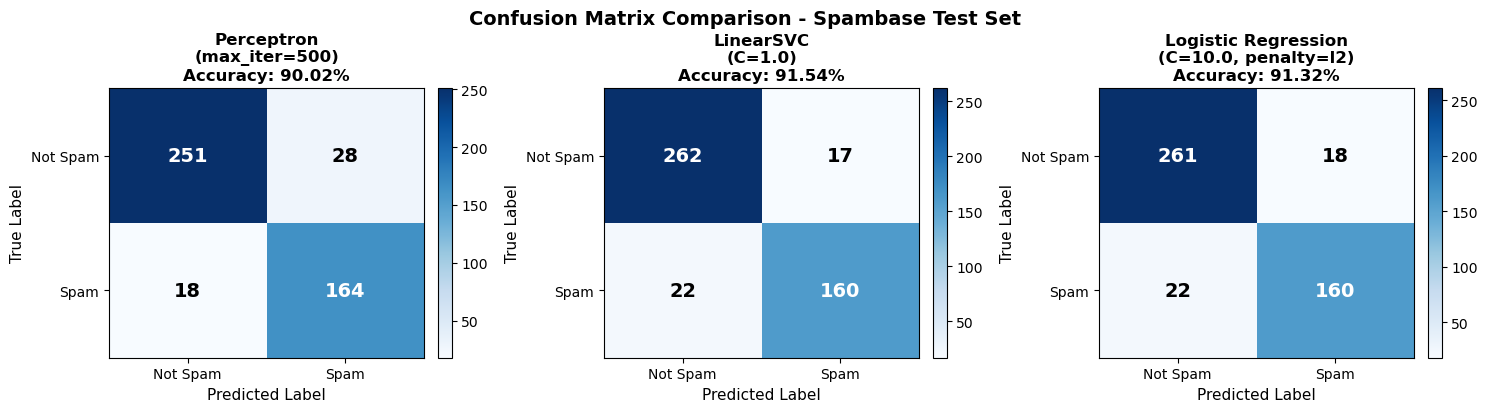


DETAILED ERROR ANALYSIS

Perceptron (max_iter=500):
  Accuracy: 90.02%
  True Negatives (Correct Non-Spam):  251
  False Positives (Non-Spam → Spam):   28
  False Negatives (Spam → Non-Spam):   18
  True Positives (Correct Spam):      164
  False Positive Rate: 10.04%
  False Negative Rate: 9.89%

LinearSVC (C=1.0):
  Accuracy: 91.54%
  True Negatives (Correct Non-Spam):  262
  False Positives (Non-Spam → Spam):   17
  False Negatives (Spam → Non-Spam):   22
  True Positives (Correct Spam):      160
  False Positive Rate: 6.09%
  False Negative Rate: 12.09%

Logistic Regression (C=10.0, penalty=l2):
  Accuracy: 91.32%
  True Negatives (Correct Non-Spam):  261
  False Positives (Non-Spam → Spam):   18
  False Negatives (Spam → Non-Spam):   22
  True Positives (Correct Spam):      160
  False Positive Rate: 6.45%
  False Negative Rate: 12.09%



In [10]:
# Visualize confusion matrices (for report)

# First, get the confusion matrices for all three models
# (Run the cell above first)

# Get confusion matrices
cm_perceptron = confusion_matrix(y_test, perceptron.predict(X_test.values))
cm_svc = confusion_matrix(y_test, linear_svc.predict(X_test))
cm_logreg = confusion_matrix(y_test, logistic_regression.predict(X_test))

# Create a figure with 3 subplots side-by-side
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Model names and confusion matrices
models = [
    ('Perceptron\n(max_iter=500)', cm_perceptron, '90.02%'),
    ('LinearSVC\n(C=1.0)', cm_svc, '91.54%'),
    ('Logistic Regression\n(C=10.0, penalty=l2)', cm_logreg, '91.32%')
]

# Plot each confusion matrix
for idx, (name, cm, acc) in enumerate(models):
    ax = axes[idx]
    
    # Create heatmap
    im = ax.imshow(cm, cmap='Blues', aspect='auto')
    
    # Add colorbar
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    # Set labels
    ax.set_xlabel('Predicted Label', fontsize=11)
    ax.set_ylabel('True Label', fontsize=11)
    ax.set_title(f'{name}\nAccuracy: {acc}', fontsize=12, fontweight='bold')
    
    # Set tick labels
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Not Spam', 'Spam'])
    ax.set_yticklabels(['Not Spam', 'Spam'])
    
    # Add text annotations for each cell
    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, cm[i, j],
                          ha="center", va="center", 
                          color="white" if cm[i, j] > cm.max() / 2 else "black",
                          fontsize=14, fontweight='bold')

plt.tight_layout()
plt.suptitle('Confusion Matrix Comparison - Spambase Test Set', 
             fontsize=14, fontweight='bold', y=1.02)
plt.show()

# Print summary statistics
print("\n" + "=" * 70)
print("DETAILED ERROR ANALYSIS")
print("=" * 70)

for name, cm, acc in models:
    tn, fp, fn, tp = cm.ravel()
    print(f"\n{name.replace(chr(10), ' ')}:")
    print(f"  Accuracy: {acc}")
    print(f"  True Negatives (Correct Non-Spam):  {tn:3d}")
    print(f"  False Positives (Non-Spam → Spam):  {fp:3d}")
    print(f"  False Negatives (Spam → Non-Spam):  {fn:3d}")
    print(f"  True Positives (Correct Spam):      {tp:3d}")
    print(f"  False Positive Rate: {fp/(tn+fp)*100:.2f}%")
    print(f"  False Negative Rate: {fn/(fn+tp)*100:.2f}%")

print("\n" + "=" * 70)